In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import tqdm.notebook as tqdm

import scipy
import networkx as nx

### Load the Dataset

In [2]:
!ls ../dataset/

 dataset.csv  'Variable Names (1).xlsx'


In [3]:
df = pd.read_csv("../dataset/dataset.csv", index_col = [0])
df


,ID,CTFLAG,ANYFX,FRAX_SCORE,PARKINS,RHEUMAT,OSTEOPOR,ARTHRIT,CANC_F30,CATARACT,...,F60VITA,TEXPWK,WALKSPD,BKBONE,BKHIP,BKBACK,BKLARM,SMOKING,YEARS_MENOPAUSE,DUR_MENA_MENO
0,131073,1,0,6.14,0.0,0.0,0.0,0.0,0.0,0.0,...,975.84083,2.50000,3.0,1.0,0.0,0.0,1.0,1.0,10.0,-45.0
1,262147,1,0,8.05,0.0,8.0,0.0,1.0,0.0,0.0,...,848.40762,26.83333,3.0,0.0,0.0,0.0,0.0,1.0,13.0,-44.0
2,131075,0,0,12.88,0.0,8.0,0.0,1.0,0.0,1.0,...,629.72861,21.00000,3.0,1.0,0.0,0.0,0.0,1.0,11.0,-45.0
3,262149,0,0,8.78,0.0,8.0,0.0,1.0,0.0,0.0,...,339.14853,32.83333,4.0,0.0,0.0,0.0,0.0,1.0,15.0,-45.0
4,262150,1,1,1.73,0.0,0.0,0.0,0.0,0.0,0.0,...,1574.51101,21.83333,3.0,0.0,0.0,0.0,0.0,0.0,19.0,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74769,262130,1,0,3.07,0.0,0.0,0.0,0.0,0.0,0.0,...,668.50414,0.00000,3.0,1.0,0.0,0.0,0.0,0.0,2.0,-46.0
74770,131066,1,0,3.94,0.0,0.0,0.0,0.0,0.0,0.0,...,334.67271,7.50000,3.0,0.0,0.0,0.0,0.0,0.0,7.0,-46.0
74771,262131,0,0,4.45,0.0,0.0,0.0,0.0,0.0,0.0,...,1195.77043,17.08333,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-47.0
74772,131068,1,0,8.54,0.0,0.0,0.0,0.0,0.0,0.0,...,1169.27512,0.00000,9.0,1.0,0.0,0.0,0.0,0.0,13.0,-45.0


In [4]:
#extract cohort, labels, patid
df = df[df["CTFLAG"] == 1]

#do not drop frax score yet
labels = df["ANYFX"]
dataset = df.drop(columns = ["ANYFX", "CTFLAG", "ID"]) 

print("Dataset Shape:", df.shape)

Dataset Shape: (31470, 67)


In [5]:
print(labels.value_counts())

ANYFX
0    27835
1     3635
Name: count, dtype: int64


### Similarity Network

In [6]:
import torch 
import torch_geometric as pyg

/u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
feature_matrix = dataset.to_numpy()

In [8]:
def gaussian_kernel(feature_matrix = None) -> np.ndarray:
    pairwise_dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(feature_matrix, 'euclidean'))
    gauss_kern = np.exp(-pairwise_dists ** 2 / pairwise_dists.std() ** 2)
    return gauss_kern

In [9]:
similarity_matrix = gaussian_kernel(feature_matrix)
similarity_matrix = torch.Tensor(similarity_matrix)

In [10]:
#change adj to edge index, edge_weight
edge_index = (similarity_matrix > 0).nonzero().t()
row, col = edge_index
edge_weight = similarity_matrix[row, col]

In [11]:
#remove self edges
edge_index, edge_weight = pyg.utils.remove_self_loops(edge_index, edge_weight)

In [12]:
threshold = 0.01

topk = int(threshold * len(edge_weight))
topk_indices = torch.topk(edge_weight, topk, largest=True).indices
edge_index = edge_index[:, topk_indices]
edge_weight = edge_weight[topk_indices]


Text(0.5, 1.0, 'Distribution of all Edges')

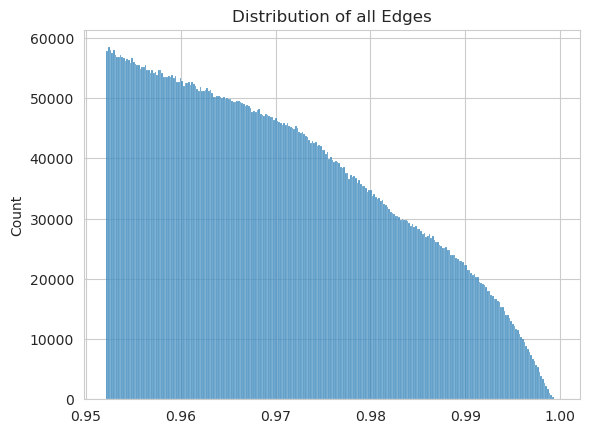

In [13]:
sns.set_style('whitegrid')
sns.histplot(edge_weight)
plt.title("Distribution of all Edges")

In [14]:
dataset

,FRAX_SCORE,PARKINS,RHEUMAT,OSTEOPOR,ARTHRIT,CANC_F30,CATARACT,DIARRHEA,ASTHMA,EMPHYSEM,...,F60VITA,TEXPWK,WALKSPD,BKBONE,BKHIP,BKBACK,BKLARM,SMOKING,YEARS_MENOPAUSE,DUR_MENA_MENO
0,6.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,975.84083,2.50000,3.0,1.0,0.0,0.0,1.0,1.0,10.0,-45.0
1,8.05,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,848.40762,26.83333,3.0,0.0,0.0,0.0,0.0,1.0,13.0,-44.0
4,1.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1574.51101,21.83333,3.0,0.0,0.0,0.0,0.0,0.0,19.0,-30.0
5,5.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1343.93763,8.75000,3.0,0.0,0.0,0.0,0.0,1.0,16.0,-36.0
6,6.90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,666.84562,11.12500,3.0,0.0,0.0,0.0,0.0,1.0,16.0,-44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74764,4.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,649.35222,4.50000,3.0,1.0,0.0,0.0,0.0,0.0,4.0,-43.0
74769,3.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,668.50414,0.00000,3.0,1.0,0.0,0.0,0.0,0.0,2.0,-46.0
74770,3.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,334.67271,7.50000,3.0,0.0,0.0,0.0,0.0,0.0,7.0,-46.0
74772,8.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1169.27512,0.00000,9.0,1.0,0.0,0.0,0.0,0.0,13.0,-45.0


In [15]:
edge_weight, edge_index = edge_weight.to(torch.float), edge_index.to(torch.long)
pyg_g = pyg.data.Data(edge_index = edge_index, edge_weight = edge_weight)

#remove the frax score before putting it in the graph - features are ready to run on 
pyg_g.x = torch.tensor(dataset.drop(columns = ["FRAX_SCORE"]).to_numpy(), dtype = torch.float32)

In [16]:
print("Similarity Network Statistics:")
print("\tnodes:", similarity_matrix.shape[0])
print("\tedges:", edge_index.shape[1])
print("\t(min edge, max edge): (%s, %s)" % (edge_weight.min().numpy(), edge_weight.max().numpy()))
print("\t(avg, std): (%s, %s)" % (edge_weight.mean(), edge_weight.var()))

Similarity Network Statistics:
	nodes: 31470
	edges: 9894023
	(min edge, max edge): (0.95217025, 0.99965084)
	(avg, std): (tensor(0.9701), tensor(0.0001))


In [17]:
dataset.drop(columns = ["FRAX_SCORE"]).to_numpy().shape

(31470, 63)

### Training Loop

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

def FRAX_maximize_youden_j(y_true: pd.Series, y_prob: pd.Series) -> float:
    """
    Finds the optimal threshold that maximizes Youden’s J Statistic (TPR - FPR).

    :param y_true: Pandas Series of true binary labels (0 or 1).
    :param y_prob: Pandas Series of predicted probabilities.
    :return: The optimal threshold for classification.
    """
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Compute Youden’s J statistic
    j_scores = tpr - fpr

    # Find the optimal threshold (maximum J score)
    best_threshold = thresholds[np.argmax(j_scores)]

    print(f"Optimal Threshold (Max Youden's J): {best_threshold:.4f}")

    return best_threshold



In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

import pandas as pd
import numpy as np

def weighted_downsample(X: pd.DataFrame, 
                        y: pd.Series, 
                        feature_list: list = ["ETHNICNIH", "RACENIH"],
                        weights_dict: dict = None, 
                        frac: float = 0.5, 
                        random_state: int = 42):

    valid_features = [f for f in feature_list if f in X.columns]
    if not valid_features:
        raise ValueError("None of the specified features exist in X.")

    #no weights_dict is provided
    if weights_dict is None:
        weights_dict = {feature: 1 / len(valid_features) for feature in valid_features}

    total_weight = sum(weights_dict.values())
    normalized_weights = {k: v / total_weight for k, v in weights_dict.items() if k in valid_features}
    sampling_weights = X[valid_features].mul(normalized_weights).sum(axis=1)
    sampling_weights = np.maximum(sampling_weights, 1e-10)  # Avoid zero probability
    sampling_weights /= sampling_weights.sum()
    downsampled_indices = (
        pd.concat([X, y], axis=1) 
        .groupby(y.name, group_keys=False)  
        .apply(lambda group: group.sample(frac=frac, weights=sampling_weights.loc[group.index], random_state=random_state))
        .index
    )

    X_downsampled = X.loc[downsampled_indices]
    y_downsampled = y.loc[downsampled_indices]

    return X_downsampled, y_downsampled


def weighted_downsample_LABELS(df, labels, target_ratio=0.5, random_state=42):
    """
    Performs weighted downsampling to balance classes in the dataset.

    :param df: DataFrame with features.
    :param labels: Series with target labels.
    :param target_ratio: Desired ratio of the minority class.
    :param random_state: Random seed for reproducibility.
    :return: Downsampled features (X) and labels (y).
    """
    # Combine features and labels into one DataFrame
    df['label'] = labels
    
    # Identify majority and minority classes
    class_counts = df['label'].value_counts()
    min_class = class_counts.idxmin()
    maj_class = class_counts.idxmax()

    # Compute the target number of samples for the majority class
    n_min = class_counts[min_class]
    n_maj = int(n_min / target_ratio - n_min)

    # Get indices of the minority and majority class
    minority_indices = df[df['label'] == min_class].index
    majority_indices = df[df['label'] == maj_class].index

    # Downsample the majority class while keeping track of indices
    df_majority_downsampled = resample(df.loc[majority_indices], 
                                       replace=False, 
                                       n_samples=n_maj, 
                                       random_state=random_state)

    # Combine the balanced dataset
    df_balanced = pd.concat([df.loc[minority_indices], df_majority_downsampled])

    # Separate features, labels, and indices
    y_balanced = df_balanced['label']
    X_balanced = df_balanced.drop(columns=['label'])
    selected_indices = df_balanced.index.to_list()  # Convert indices to a list

    return X_balanced, y_balanced, selected_indices




In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

def evaluate_model(y_true, y_pred, y_prob=None, descr = None):
    """
    Computes and prints standard classification metrics: Accuracy, AUC, Precision, Recall, and F1-score.

    :param y_true: List or array of true labels (0 or 1).
    :param y_pred: List or array of predicted labels (0 or 1).
    :param y_prob: List or array of predicted probabilities (optional, needed for AUC).
    :return: Dictionary containing Accuracy, AUC, Precision, Recall, and F1-score.
    """
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, y_prob) 
    }

    # Print metrics
    if descr:
        print(descr)
    for key, value in metrics.items():
        print(f"\t{key}: {value:.4f}" if value is not None else f"{key}: N/A (Only one class present)")

    return metrics

    
    #extract featuresd
    y_pred = model.predict(X_train_balanced)
    y_prob = model.predict_proba(X_train_balanced)[:, 1]

def eval_run(model, x, y, descr = None):
    y_pred = model.predict(x)
    y_prob = model.predict_proba(x)[:, 1]
    evaluate_model(y, y_pred, y_prob, descr = descr)

def eval_frax(frax_scores, labels, descr = None, threshold = None):
    if threshold:
        pass
    else:
        threshold = FRAX_maximize_youden_j(labels, frax_scores)
    y_pred = (frax_scores >= threshold).astype(int)
    evaluate_model(labels, y_pred, frax_scores, descr = descr)
    return threshold



In [31]:
random_cv_avail = True

import scipy

param_dist = {
    'n_estimators': scipy.stats.randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

### Defining the Model

In [32]:
!nvidia-smi

Mon Mar 10 03:07:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:46:00.0 Off |                    0 |
| N/A   31C    P0             65W /  400W |     639MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [33]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        """
        Implements Focal Loss for binary classification.
        Args:
            alpha (float): Balancing factor for class weights.
            gamma (float): Focusing parameter for hard examples.
            reduction (str): 'mean' (default) or 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")  # Keep raw loss for focal scaling

    def forward(self, logits, targets):
        """
        Args:
            logits: Raw model outputs (before sigmoid).
            targets: Ground truth labels (binary, 0 or 1).
        Returns:
            Focal Loss value.
        """
        bce_loss = self.bce_loss(logits, targets)  # Compute standard BCE loss
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        targets = targets.float()

        # Compute focal loss scaling factor
        p_t = targets * probs + (1 - targets) * (1 - probs)
        focal_factor = (1 - p_t) ** self.gamma

        # Apply alpha weighting (for class balance)
        alpha_factor = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        # Compute final focal loss
        loss = alpha_factor * focal_factor * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss  # No reduction (per-sample loss)

In [34]:
import torch
import torch_geometric as pyg

print(torch.cuda.is_available())
print([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

True


In [35]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_layers, num_heads, node_features=63, hidden_channels=12, out_channels=1):
        super(GAT, self).__init__()

        self.num_layers = num_layers  
        self.module_list = torch.nn.ModuleList()

        # Input layer
        self.in_layer = GATConv(in_channels=node_features, 
                                out_channels=hidden_channels, 
                                heads=num_heads, 
                                concat=True)

        # Hidden layers
        for _ in range(num_layers):
            self.module_list.append(GATConv(in_channels=hidden_channels * num_heads, 
                                            out_channels=hidden_channels, 
                                            heads=num_heads, 
                                            concat=True))


        self.out_layer = Linear(hidden_channels * num_heads, out_channels)

    def forward(self, x, edge_index):

        x = self.in_layer(x, edge_index)
        x = F.relu(x)  

        for layer in self.module_list:
            x = layer(x, edge_index)
        
        x = self.out_layer(x)
        return x


In [40]:
import torch.optim as optim

device = torch.device("cuda:0")

pyg_g.edge_index = pyg_g.edge_index.to(device)
pyg_g.edge_weight = pyg_g.edge_weight.to(device)
pyg_g.x = pyg_g.x.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [38]:
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm

n_splits = 5
random_state = 45
target_ratio=0.5
epoch_num = 100

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
scores = []


#model list for 5fold cv, 3 layer GAT with 4 attention heads each
model_list = [GAT(num_layers = 3, num_heads = 2).to(device) for i in range(5)]
pyg_g = pyg_g.to(device)

for fold, (train_idx, test_idx) in enumerate(skf.split(dataset, labels)):
    
    model = model_list[fold].to(device)
    
    # Loss, Optimizer, Scheduler
    criterion = FocalLoss().to(device)  
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  
    
    print(f"Fold {fold+1}/{n_splits}--------------------------")

    # Split train and test sets
    X_train, X_test = dataset.iloc[train_idx], dataset.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
    
    # Perform weighted downsampling on training data
    X_train_balanced, y_train_balanced, downsampled_indices = weighted_downsample_LABELS(X_train, y_train, target_ratio = 0.3)
    print("Training Fold Label Distr:", dict(pd.Series(y_train_balanced).value_counts()))
    
    #get frax after downsample
    frax_score_train, frax_score_test = X_train_balanced["FRAX_SCORE"], X_test["FRAX_SCORE"]
    X_train_balanced, X_test = X_train_balanced.drop(columns = ["FRAX_SCORE"]), X_test.drop(columns = ["FRAX_SCORE"])
   
    #eval frax
    FRAX_threshold = eval_frax(frax_score_train, y_train_balanced, descr = "FRAX Train:")
    
    y_train_balanced = torch.tensor(y_train_balanced.to_numpy()).to(device)
    print(y_train_balanced)
    #########################################################
    #train model
    for i in tqdm(range(epoch_num), desc = "TRAIN GNN"):
        
        model.train()
        optimizer.zero_grad()

        #run entire graph through gnn
        out = model(pyg_g.x, pyg_g.edge_index)
        
        #flatten to match shape, run through BCE focal loss
        #loss only calculated from train nodes
        loss = criterion(out.squeeze()[downsampled_indices], y_train_balanced[downsampled_indices])
        
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    
    print("Fold Label Distr:", dict(pd.Series(y_test).value_counts()))
    print("\n")


Fold 1/5--------------------------
Training Fold Label Distr: {0: 6785, 1: 2908}
Optimal Threshold (Max Youden's J): 6.9800
FRAX Train:
	Accuracy: 0.5927
	Precision: 0.3637
	Recall: 0.4773
	F1-score: 0.4128
	AUC: 0.5836
tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')


TRAIN GNN:   0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [11,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [13,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [14,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [6,0,0], thread: [15,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [39]:
num_nodes = pyg_g.x.shape[0]  # Total number of nodes in the graph

# Check for out-of-bounds indices
if (edge_index < 0).any() or (edge_index >= num_nodes).any():
    print("Error: edge_index contains out-of-bounds indices!")


In [41]:
import torch_sparse
print(torch_sparse.__version__)


OSError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/libpyg.so)

In [42]:
import pyg_lib

OSError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /u/irsyadadam/.conda/envs/pyg_CUDA/lib/python3.11/site-packages/libpyg.so)